In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from scipy import stats
from scipy.stats import mannwhitneyu
import warnings
warnings.filterwarnings(action = 'ignore')
plt.style.use('seaborn')

## Dataloader
- Importing the data from a CSV file 
- Getting rid of the index column from the CSV
- Shape of dataset (1460, 81)
- Since the dataset contains variable amounts of null values in each column we decide to drop only the columns which have higher percentage of null values than the user input
- Rest of the null value rows are dropped since it's not too many

In [3]:
def dataLoader(path:str, thresh:int = 0.2)->pd.DataFrame:
    '''
    Load the data. Drop cols with null threshold more than thresh param.
    '''
    data = pd.read_csv(path)
    data = data.drop('Id', axis = 1)
    null_cols = data.isnull().sum()[data.isnull().sum()/len(data) > thresh]
    null_cols_list = null_cols.index
    data.drop(null_cols_list, axis = 1, inplace = True)
    data.dropna(inplace = True)
    print(f'data shape: {data.shape}')
    return data

In [4]:
data = dataLoader('train.csv', 0.15)
data.head()

data shape: (1338, 74)


,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,...,0,0,0,0,0,2,2008,WD,Normal,208500
1,20,RL,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,...,0,0,0,0,0,5,2007,WD,Normal,181500
2,60,RL,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,...,0,0,0,0,0,9,2008,WD,Normal,223500
3,70,RL,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,...,272,0,0,0,0,2,2006,WD,Abnorml,140000
4,60,RL,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,...,0,0,0,0,0,12,2008,WD,Normal,250000


## Dataseg
### Seperating the numerical data from categorical data
- Dropping the target column 'SalesPrice'
- Seperating columns based on dtypes for further processing

### Seperating the numerical data 
- Seperating the numerical data into ordinal values by checking the number of unique values in the column
- Seperating the columns containig datetime data for Traget encoding

### Further seperating the categorical data
- Selecting categorical columns with fewer unique values for One Hot Encoding
- The rest would go for Target Encoding

In [5]:
def dataSeg(data:pd.DataFrame)->pd.DataFrame:
    '''
    Separates the numerical data from cat data.
    y = Target Series
    num = DataFrame with only numerical values
    cat = DataFrame with only object values
    '''
    input_data = data.drop('SalePrice', axis = 1)
    y  = data['SalePrice']
    num = input_data.select_dtypes(exclude = 'object')
    cat = input_data.select_dtypes(include = 'object')
    
    '''
    Seperates the numerical data suitable for standardization, numerical ordinal data and year data for Target Encoding
    int_data = DataFrame for standardization(columns which had nunique > 50)
    ordinal_data = DataFrame containing ordinal columns(columns which had nunique < 50)
    int_year_data = DataFrame containing year columns 
    '''
    int_data_temp = num.nunique()[(num.nunique()>50) & (~num.columns.str.match('Year|Yr|[A-za-z]+Yr'))]
    ordinal_data_temp = num.nunique()[(num.nunique()<50) & (~num.columns.str.match('Year|Yr|[A-za-z]+Yr'))]
    int_year_data_temp = num.nunique()[num.columns.str.match('Year|Yr|[A-za-z]+Yr')]#.astype(str)
    int_data = num.loc[:, int_data_temp.index]
    ordinal_data = num.loc[:, ordinal_data_temp.index]
    int_year_data = num.loc[:, int_year_data_temp.index]
    
    '''
    Seperates the categorical data suitable for OHE and Traget Encoding
    cat_data_ohe = DataFrame containing object data for OHE(columns which had nunique < 10)
    cat_data_tc = DataFrame containing object data for TargetEncoding(columns which had nunique > 10)
    '''
    cat_cols_ohe_temp = cat.nunique()[cat.nunique()<10]
    cat_cols_tc_temp = cat.nunique()[cat.nunique()>10]
    cat_data_ohe = cat.loc[:, cat_cols_ohe_temp.index]
    cat_data_tc = cat.loc[:, cat_cols_tc_temp.index]
    
    
    return y, int_data, ordinal_data, int_year_data, cat_data_ohe, cat_data_tc

In [6]:
y, int_data, ordinal_data, int_year_data, cat_data_ohe, cat_data_tc = dataSeg(data)

## RemoveOutliers
- Handling the outliers in the numerical columns by replacing the values which are outside of 1.5 * IQR with the median
- Dropping columns with only zero values
- Standrdizing the numerical dataset

In [7]:
def removeOutliers(data: pd.DataFrame)->pd.DataFrame:
    
    iqr = data.apply(lambda x: stats.iqr(x))
    q3 = data.apply(lambda x: x.quantile(0.75))
    q1 = data.apply(lambda x: x.quantile(0.25))
    ul = q3 + 1.5 * iqr
    ll = q1 - 1.5 * iqr
    try:
        assert len(ul) == len(ll)
        new_data = data.apply(lambda x: [x.median() if (i > ul[x.name] or i < ll[x.name]) else i for i in x])
    except AssertionError:
        print(f'Columns are mismatching: {ul}, {ll}')
    new_data1 = new_data.drop(new_data.sum()[new_data.sum() == 0].index, axis = 1)
    new_data_std = (new_data1 - new_data1.mean())/new_data1.std()
    return new_data_std

In [8]:
new_data_std = removeOutliers(int_data)
new_data_std.head()

,LotArea,MasVnrArea,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,GarageArea,WoodDeckSF,OpenPorchSF
0,-0.335239,1.119230,0.592536,-1.015962,-0.627452,-0.875256,1.146109,0.483464,0.377844,-0.806724,0.547384
1,0.042933,-0.627961,1.232478,-0.678103,0.549352,0.305548,-0.812224,-0.538437,-0.161709,1.912642,-0.841937
2,0.585528,0.816146,0.074936,-0.299903,-0.441946,-0.689120,1.173627,0.656822,0.745720,-0.806724,0.114645
3,0.026491,-0.627961,-0.560301,-0.032642,-0.917306,-0.569876,0.921382,0.499431,0.954184,-0.806724,-0.044786
4,1.575353,2.492024,0.472547,-0.158708,0.210224,-0.034733,1.602442,1.596607,2.143652,0.945351,1.071227


## Encoding
- Applying One Hot Enconding on categorical columns which have fewer unique values in them
- Applying target encoding on columns with large amount of unique values and for the columns containing 'Year' data

In [9]:
from category_encoders import TargetEncoder
def encoding(int_year_data:pd.DataFrame, cat_data_ohe:pd.DataFrame, cat_data_tc:pd.DataFrame)->pd.DataFrame:
    
    '''
    after_ohe_cat = Categoriacal columns OHE(nunique < 10)
    '''
    after_ohe_cat = pd.get_dummies(cat_data_ohe, drop_first = True)
    
    '''
    after_tc_year_std = Year column target encoded and standardized
    after_tc_cat_std = Categorical column(nunique > 10) target encoded and standardized
    '''
    encoder = TargetEncoder()
    after_tc_year_temp = encoder.fit_transform(int_year_data.astype(str), y)
    after_tc_cat_temp = encoder.fit_transform(cat_data_tc, y)
    after_tc_year_std = (after_tc_year_temp - after_tc_year_temp.mean()) / after_tc_year_temp.std()
    after_tc_cat_std = (after_tc_cat_temp - after_tc_cat_temp.mean()) / after_tc_cat_temp.std()
    
    
    return after_ohe_cat, after_tc_year_std, after_tc_cat_std

In [10]:
after_ohe_cat, after_tc_year, after_tc_cat = encoding(int_year_data, cat_data_ohe, cat_data_tc)
after_tc_cat.head()

,Neighborhood,Exterior1st,Exterior2nd
0,0.229513,1.017326,1.065322
1,0.288626,-1.147664,-1.145377
2,0.229513,1.017326,1.065322
3,0.441819,-1.028007,-0.391987
4,2.566628,1.017326,1.065322


## Feature_Concat
- Concatenating all the processed columns for modelling

In [11]:
def feature_concat(*args):
    features_for_model = pd.concat(args, axis = 1)
    return features_for_model

In [12]:
feature = feature_concat(new_data_std, ordinal_data, after_ohe_cat, after_tc_year, after_tc_cat)
feature.shape

(1338, 174)

### Since the target columns is slightly right skewed we apply some transformation like log and Box-Cox

### Linear Model with log target

In [13]:
y_log = np.log1p(y)
y_log.head()
# sns.distplot(y_log);
# print(stats.shapiro(y_log))

0    12.247699
1    12.109016
2    12.317171
3    11.849405
4    12.429220
Name: SalePrice, dtype: float64

In [14]:
from sklearn.model_selection import cross_val_score
log_model = cross_val_score(LinearRegression(), feature, y_log, cv = 10)
log_model.mean()

0.864398186246196

### Linear Model with box cox transformed traget

In [15]:
box_cox_y, lambda_ = stats.boxcox(y)
# sns.distplot(box_cox_y);
# print(stats.shapiro(box_cox_y))

In [16]:
box_cox_model = cross_val_score(LinearRegression(), feature, box_cox_y, cv = 10)
box_cox_model.mean()

0.8623702256015211

### Ridge Model

In [27]:
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
#Finding best alpha
ridge_cv_model = RidgeCV(alphas = np.linspace(1,1.4,50))
ridge_cv_model.fit(feature, box_cox_y)
ridge_cv_model.alpha_

1.1714285714285715

In [28]:
ridge_model = cross_val_score(Ridge(alpha = 1.171), feature, box_cox_y, cv = 10)
ridge_model.mean()

0.8826865190354848

In [37]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree), Ridge(alpha = 1.171,**kwargs))

In [39]:
ridge_polynimial_score = cross_val_score(PolynomialRegression(), feature, box_cox_y, cv = 5)
ridge_polynimial_score.mean()

-1.0993208798827672

### Lasso Model

In [20]:
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV

### Checking Distribution

In [21]:
# Pre outlier removal
for_sample = pd.concat([int_data, ordinal_data], axis = 1)
first_sample = for_sample.sample(frac = 0.33, random_state = 1)
other_part = for_sample.drop(first_sample.index)
second_sample = other_part.sample(frac = 0.5, random_state = 1)
third_sample = other_part.drop(second_sample.index)

print(first_sample.shape, second_sample.shape, third_sample.shape)

(442, 31) (448, 31) (448, 31)


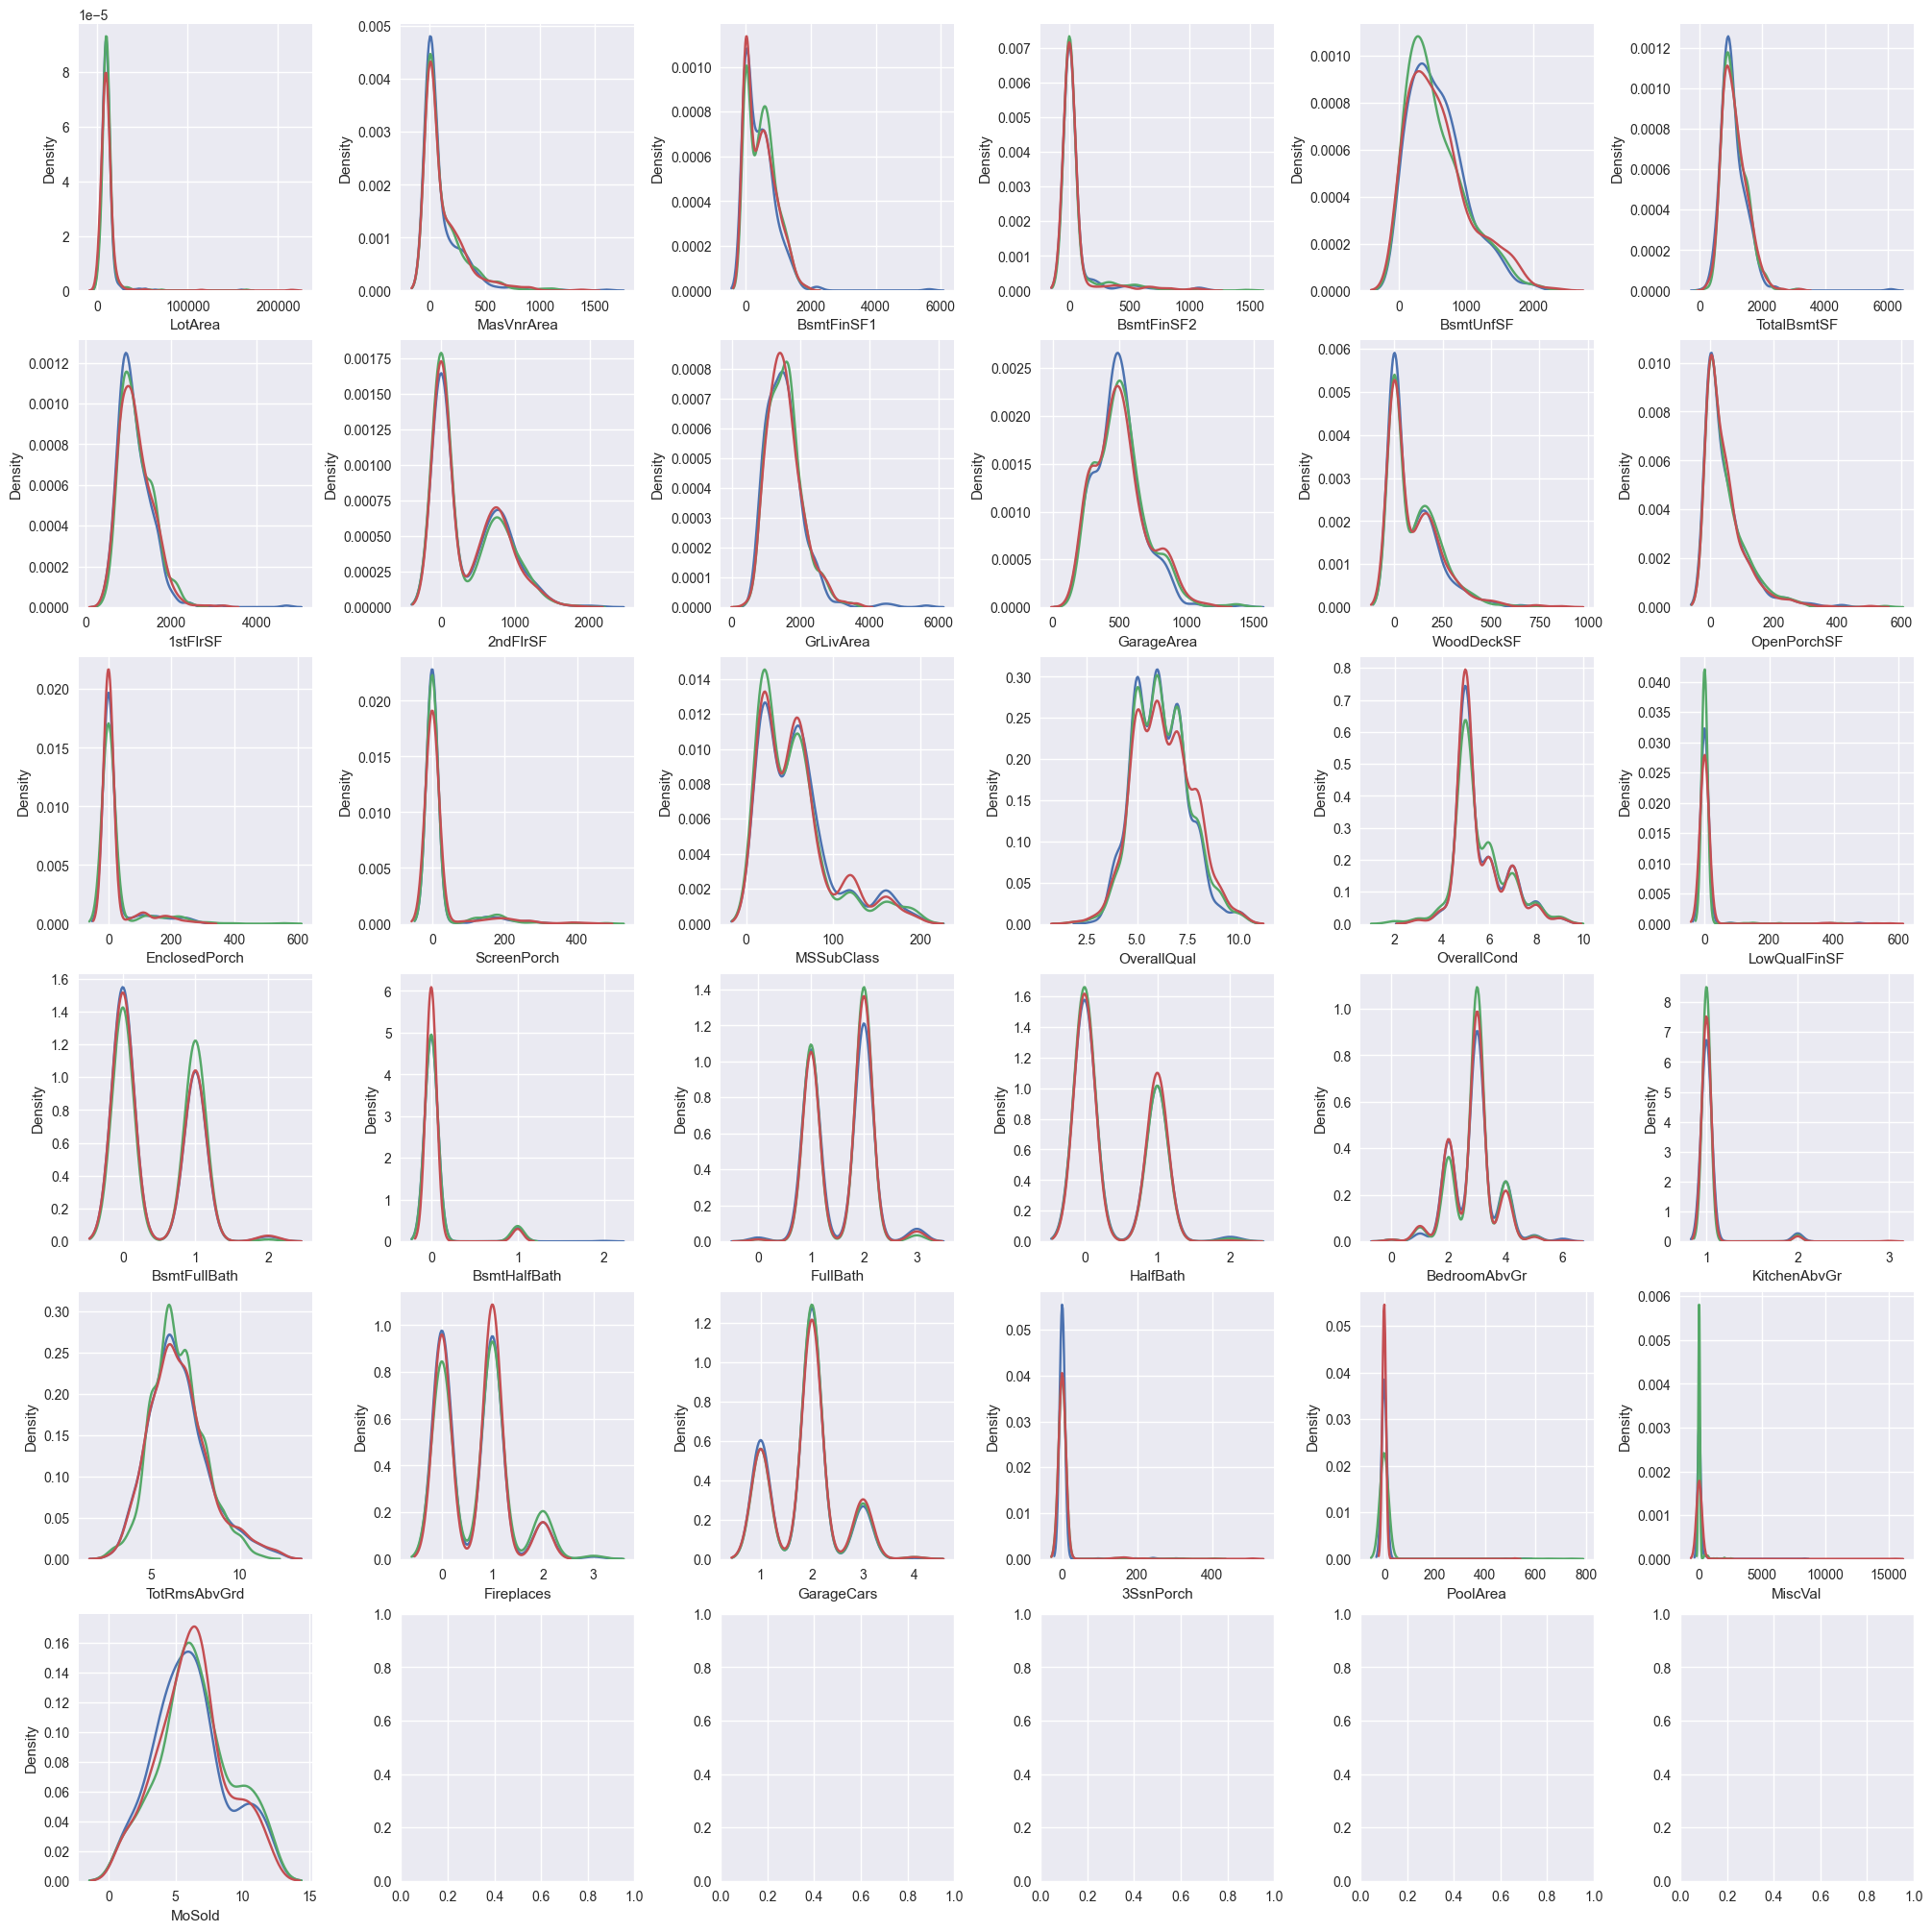

In [22]:
fig, ax = plt.subplots(6, 6, figsize = (20,20), layout = 'constrained')
cnt = 0
for i in first_sample.columns:
    sns.kdeplot(data = first_sample[i], ax = ax.flat[cnt])
    sns.kdeplot(data = second_sample[i], ax = ax.flat[cnt])
    sns.kdeplot(data = third_sample[i], ax = ax.flat[cnt])
    cnt += 1

##### Mann Whitney U test

In [23]:
def mann_whitney_u_test(series):
    mwu_test_sample_1 = series.sample(n = 15, replace = False, random_state = 1)
    mwu_test_sample_2 = series.sample(n = 15, replace = False, random_state = 3)
    stat, p_value = mannwhitneyu(mwu_test_sample_1.to_numpy(), mwu_test_sample_2.to_numpy())
    return p_value

In [24]:
x = for_sample.apply(lambda x: mann_whitney_u_test(x))
x

LotArea          0.693518
MasVnrArea       0.743045
BsmtFinSF1       0.785497
BsmtFinSF2       0.350648
BsmtUnfSF        0.184410
TotalBsmtSF      0.589739
1stFlrSF         0.693518
2ndFlrSF         0.573621
GrLivArea        0.350634
GarageArea       0.046438
WoodDeckSF       0.862598
OpenPorchSF      0.964089
EnclosedPorch    0.916158
ScreenPorch      0.350648
MSSubClass       0.725579
OverallQual      0.161038
OverallCond      0.098082
LowQualFinSF     0.164394
BsmtFullBath     0.409395
BsmtHalfBath     0.164394
FullBath         0.725521
HalfBath         0.021849
BedroomAbvGr     0.907202
KitchenAbvGr     1.000000
TotRmsAbvGrd     0.604406
Fireplaces       0.251263
GarageCars       0.018206
3SsnPorch        1.000000
PoolArea         1.000000
MiscVal          1.000000
MoSold           0.737963
dtype: float64

##### https://sphweb.bumc.bu.edu/otlt/mph-modules/bs/bs704_nonparametric/bs704_nonparametric4.html

In [25]:
# from sklearn.pipeline import make_pipeline
# from sklearn.preprocessing import PolynomialFeatures
# from sklearn.model_selection import validation_curve
# from sklearn.metrics import make_scorer, mean_absolute_error
# def PolynomialRegression(degree=1, **kwargs):
#     return make_pipeline(PolynomialFeatures(degree), LinearRegression(**kwargs))

In [26]:
# import numpy as np
# scorer = make_scorer(mean_absolute_error)
# degree = np.arange(1,3)
# train_err, val_err = validation_curve(estimator = PolynomialRegression(), X = feature, y = y,
#                                       param_name='polynomialfeatures__degree', 
#                                       param_range=degree, cv=3, scoring = scorer)
# plt.plot(degree, np.mean(train_err,1), color='blue', label='training error')
# plt.plot(degree, np.mean(val_err,1), color='red', label='validation error')
# plt.legend(loc='best');